# Kaggle 案例之“旧金山犯罪分类”

## 1、分析需求

In [1]:
import numpy as np
import pandas as pd
import os

train = pd.read_csv('../input/train.csv', parse_dates=['Dates'])
test = pd.read_csv('../input/test.csv', parse_dates=['Dates'])

In [2]:
train.head()

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541


In [3]:
test.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


评价指标：
$$
log loss = -\frac{1}{N}\sum_{i=1}^N\sum_{j=1}^My_{ij}\log(p_{ij}),
$$

样本的各个特征以及含义如下：

| 序号   | 特征名     | 解释                              |
| ---------- | --------------------------------- | --------------------------------- |
| 1      | Date       | 日期                              |
| 2  | Category   | 犯罪类型，比如 Larceny 盗窃罪 等 |
| 3  | Descript   | 对于犯罪更详细的描述              |
| 4 | DayOfWeek  | 星期几                            |
| 5 | PdDistrict | 所属警区                          |
| 6 | Resolution | 处理结果                          |
| 7   | Address    | 发生街区位置                      |
| 8         | X          | 经度                              |
| 0         | Y          | 纬度                              |



In [4]:
# 目标变量
y = train.Category

In [5]:
# 一共 39 个类别
len(y.unique())

39

In [6]:
Id = test.Id

## 2、探索性数据分析

In [7]:
weekdays = pd.get_dummies(train.DayOfWeek)
district = pd.get_dummies(train.PdDistrict)

In [8]:
weekdays.shape

(878049, 7)

In [9]:
district.shape

(878049, 10)

In [10]:
DayOfWeek_value_counts = train.DayOfWeek.value_counts()
DayOfWeek_value_counts

Friday       133734
Wednesday    129211
Saturday     126810
Thursday     125038
Tuesday      124965
Monday       121584
Sunday       116707
Name: DayOfWeek, dtype: int64

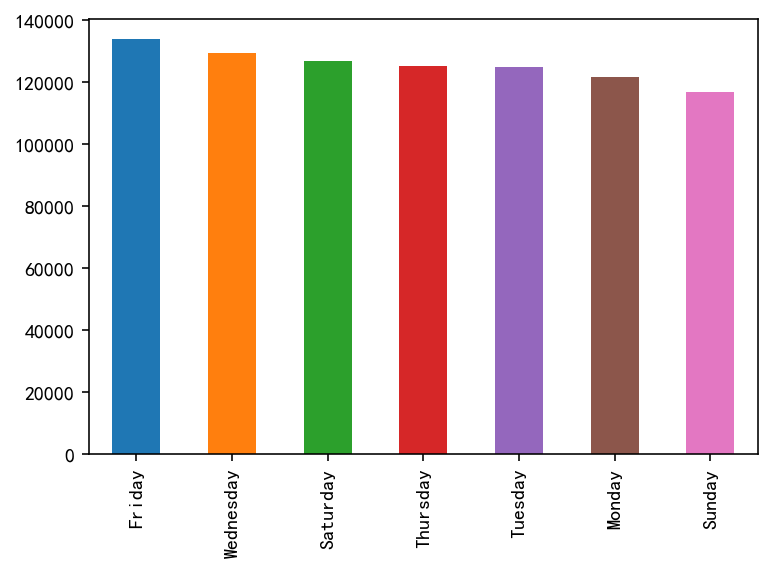

In [11]:
DayOfWeek_value_counts.plot(kind='bar')
plt.show()

可以看出周五犯罪的案件最多。

## 3、特征工程

+ 先处理训练数据集。

In [12]:
X = pd.concat(
    [
        train.Dates.dt.year, train.Dates.dt.month, train.Dates.dt.day,
        train.Dates.dt.hour, weekdays, district
    ],
    axis=1)

In [13]:
pd.options.display.max_columns = 100
print(X.shape)
X.head()

(878049, 21)


,Dates,Dates,Dates,Dates,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,BAYVIEW,CENTRAL,INGLESIDE,MISSION,NORTHERN,PARK,RICHMOND,SOUTHERN,TARAVAL,TENDERLOIN
0,2015,5,13,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,2015,5,13,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,2015,5,13,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
3,2015,5,13,23,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
4,2015,5,13,23,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


+ 再处理测试数据集。

In [14]:
weekdays = pd.get_dummies(test.DayOfWeek)
district = pd.get_dummies(test.PdDistrict)

data_test = pd.concat(
    [
        test.Dates.dt.year, test.Dates.dt.month, test.Dates.dt.day,
        test.Dates.dt.hour, weekdays, district
    ],
    axis=1)

In [15]:
print(data_test.shape)
data_test.shape

(884262, 21)


(884262, 21)

## 4、模型训练与评估

（1）分割训练集与验证集

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

（2）使用多项式朴素贝叶斯

In [17]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred = mnb.predict(X_test)

（3）模型评估

In [18]:
from sklearn.metrics import log_loss

predict_proba = mnb.predict_proba(X_test)
print(log_loss(y_test, predict_proba))

2.651474878145174


（4）使用全部训练数据

In [19]:
%%time
mnb = MultinomialNB()
mnb.fit(X, y)

CPU times: user 5.2 s, sys: 401 ms, total: 5.6 s
Wall time: 5.1 s


## 5、预测并提交

In [20]:
%%time
y_pred_proba = mnb.predict_proba(data_test)

CPU times: user 1.98 s, sys: 881 ms, total: 2.86 s
Wall time: 2.11 s


In [22]:
%%time
result = pd.DataFrame(y_pred_proba, columns=mnb.classes_)
result.to_csv('../output/MultinomialNB_2019_5_27.csv', index = True, index_label = 'Id' )
# 2.65261

CPU times: user 1min 2s, sys: 1.51 s, total: 1min 3s
Wall time: 1min 4s


## 参考资料

1、https://blog.csdn.net/Wiking__acm/article/details/48448933?utm_source=blogxgwz3